In [1]:
import numpy as np
import h5py
from scipy.ndimage import gaussian_filter1d as gauss_conv
from numba.decorators import jit
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline

In [2]:
import os
print(os.environ['PYTHONPATH'])

/home/liac/python-lib/chandra_psf:/home/liac/dev/cloudacademyMap:/home/liac/dev/cloudacademyMap/gas_opac


In [3]:
cd ~/dev/cloudacademyMap/gas_opac/

/home/liac/dev/cloudacademyMap/gas_opac


In [4]:
import opacity_demo as demo

In [7]:
# Specify which molecules you want to extract from the database (full list available in the readme)
chemical_species = np.array(['H2O', 'CH4', 'NH3', 'HCN', 'CO', 'CO2'])

# At what temperature and pressure do you desire the cross sections?
P = 1.0e-3    # Pressure (bar)
T = 1000.0    # Temperature (K)        

# Specify wavelength grid to extract cross section onto
wl_min = 0.4  # Minimum wavelength of grid (micron)
wl_max = 5.0  # Maximum wavelength of grid (micron)
N_wl = 1000   # Number of wavelength points

wl = np.linspace(wl_min, wl_max, N_wl)  # Uniform grid used here for demonstration purposes   

# Either sample the nearest wavelength points from the high resolution (R~10^6) cross section database or use an averaging prescription 
opacity_treatment = 'Log-avg'           # Options: Opacity-sample / Log-avg
#opacity_treatment = 'Opacity-sample'   # Opacity sampling is faster, but for low-resolution wavelength grids log averaging is recommended
  
# Extract desired cross sections from the database
cross_sections = demo.Extract_opacity(chemical_species, P, T, wl, opacity_treatment)   # Format: np array(N_species, N_wl) / Units: (m^2 / species)

Now reading in cross sections
H2O done
CH4 done
NH3 done
HCN done
CO done
CO2 done


In [11]:
# Example: seperate H2O cross section, and print to terminal
H2O_cross_section = cross_sections['H2O']    # Format: np array(N_wl) / Units: (m^2 / molecule)
#print (H2O_cross_section)

In [39]:
# Copy/paste plot function from opacity_demo.py because I'm getting some weird errors

def plot_opacity(chemical_species, sigma_stored, P, T, wl_grid, **kwargs):

    # Max number of species this can plot is 9 (clustered beyond that!)                                                                                                  

    # Optional smoothing of cross sections (can improve clarity)                                                                                                         
    smooth = False
    smooth_factor = 5

    # Specify cross sections to plot, along with colours for each                                                                                                        
    #colours_plot = np.array(['royalblue', 'purple', 'crimson', 'orange', 'black', 'grey', 'green', 'magenta', 'chocolate'])                                             

    # Initialise plot                                                                                                                                                    
    #ax = plt.gca()
    #ax.set_xscale("log")                                                                                                                                                

    ax = plt.subplot(111)
    #xmajorLocator   = MultipleLocator(1.0)
    #xmajorFormatter = FormatStrFormatter('%.1f')
    #xminorLocator   = MultipleLocator(0.2)

    #ax.xaxis.set_major_locator(xmajorLocator)
    #ax.xaxis.set_major_formatter(xmajorFormatter)
    #ax.xaxis.set_minor_locator(xminorLocator)

    # Plot each cross section                                                                                                                                            
    for species in chemical_species:
        #species_idx = np.where(chemical_species == species)[0][0]
        sigma_plt = sigma_stored[species]*1.0e4   # Cross section of species q at given (P,T) pair (cm^2)                                                          

        if (smooth == True):
            sigma_plt = gauss_conv(sigma_plt, sigma=smooth_factor, mode='nearest')

        # Plot cross section                                                                                                                                             
        plt.semilogy(wl_grid, sigma_plt, label = species, **kwargs)

    plt.ylim([1.0e-28, 2.0e-18])
    plt.xlim([min(wl_grid), max(wl_grid)])
    plt.ylabel(r'$\mathrm{Cross \, \, Section \, \, (cm^{2})}$', fontsize = 15)
    plt.xlabel(r'$\mathrm{Wavelength} \; \mathrm{(\mu m)}$', fontsize = 15)

    ax.text(min(wl_grid)*1.05, 6.0e-19, (r'$\mathrm{T = }$' + str(T) + r'$\mathrm{K \, \, P = }$' + str(P*1000) + r'$\mathrm{mbar}$'), fontsize = 14)

    legend = plt.legend(loc='upper right', frameon=False, prop={'size':6}, ncol=2)

    '''for legline in legend.legendHandles:
        legline.set_linewidth(1.0)'''
    return

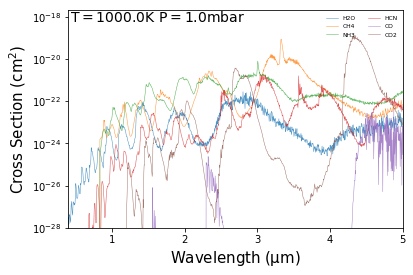

In [41]:
# Plot cross sections
plot_opacity(chemical_species, cross_sections, P, T, wl, lw=0.5, alpha=0.8)

## Grab all the opacities possible

Based on gases present both in Ryan's library and in the static weather output.

In [15]:
# Grabbed from Readme.txt
RMcD_gas = np.array(['H3+', 'Na', 'K', 'Li', 'Rb', 'Cs', 'H2', 'H2O', 'CH4', 'NH3', 'HCN', 'CO', \
                     'CO2', 'C2H2', 'H2S', 'N2', 'O2', 'O3', 'OH', 'NO', 'SO2', 'PH3', 'TiO', 'VO', \
                     'ALO', 'SiO', 'CaO', 'TiH', 'CrH', 'FeH', 'ScH', 'AlH', 'SiH', 'BeH', 'CaH', \
                     'MgH', 'LiH', 'SiH', 'CH', 'SH', 'NH'])

RMcD_gas_upper = np.array([g.upper() for g in RMcD_gas])

In [16]:
np.array(RMcD_gas_upper) == 'TIO'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [17]:
cd ..

/home/liac/dev/cloudacademyMap


In [18]:
from maplib import load_out3

In [19]:
cd ~/Dropbox/Science/cloud-academy/Les_Houches_Cloud_Activity/

/home/liac/Dropbox/Science/cloud-academy/Les_Houches_Cloud_Activity


In [20]:
# An example file to work from. I hope all of the reported columns are the same
PHI, THETA = -180, 0

# Get gas information
thermo = load_out3('thermo', PHI, THETA)

# Get wavelengths for later
wavel = load_out3('wavel', PHI, THETA)

In [21]:
thermo_gas = []
for k in thermo.keys():
    x = k.split('n_')
    if len(x) == 2:
        thermo_gas.append(x[1])
print(thermo_gas)

['H', 'Na', 'Mg', 'Fe', 'Ca', 'Al', 'Ti', 'C', 'TIO', 'TIO2', 'TIS', 'SIO', 'SIS', 'SIH', 'H2O', 'H2', 'H2S', 'MGH', 'MGOH', 'MG(OH)2', 'FEO', 'FES', 'FEH', 'FE(OH)2', 'ALOH', 'ALH', 'AL2O', 'ALO2H', 'CAO', 'CA(OH)2', 'CAS', 'CAOH', 'CAH', 'C2', 'C3', 'C2H', 'C2H2', 'CH4']


In [22]:
# Gases in static_weather model that are also in Ryan's opacity library
gases, gases_missing = [], []
for g in thermo_gas:
    if g in RMcD_gas_upper:
        ig = np.where(RMcD_gas_upper == g)[0]
        gases.append(RMcD_gas[ig][0])
    else:
        gases_missing.append(g)

In [23]:
print("Gases in both static_weather and Ryan's opacity library: ({} total)".format(len(gases)))
print(gases)
print("\nGases missing opacities: ({} total)".format(len(gases_missing)))
print(gases_missing)

Gases in both static_weather and Ryan's opacity library: (13 total)
['TiO', 'SiO', 'SiH', 'H2O', 'H2', 'H2S', 'MgH', 'FeH', 'AlH', 'CaO', 'CaH', 'C2H2', 'CH4']

Gases missing opacities: (25 total)
['H', 'Na', 'Mg', 'Fe', 'Ca', 'Al', 'Ti', 'C', 'TIO2', 'TIS', 'SIS', 'MGOH', 'MG(OH)2', 'FEO', 'FES', 'FE(OH)2', 'ALOH', 'AL2O', 'ALO2H', 'CA(OH)2', 'CAS', 'CAOH', 'C2', 'C3', 'C2H']


In [24]:
cd ~/dev/cloudacademyMap/gas_opac

/home/liac/dev/cloudacademyMap/gas_opac


**Takes a few minutes to read in**

In [26]:
%%time
sw_xsects = demo.Extract_opacity(np.array(gases), P, T, wavel, opacity_treatment)

Now reading in cross sections
TiO done
SiO done
SiH done
H2O done
H2 done
H2S done
MgH done
FeH done
AlH done
CaO done
CaH done
C2H2 done
CH4 done
CPU times: user 1min 19s, sys: 27.4 s, total: 1min 46s
Wall time: 2min 12s


(0.2, 330)

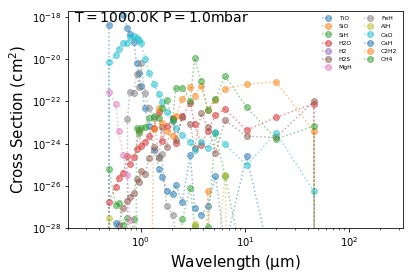

In [42]:
plot_opacity(np.array(gases), sw_xsects, P, T, wavel, marker='o', ls=':', alpha=0.5)
plt.semilogx()
plt.xlim(0.2, 330)

In [30]:
len(thermo['p'])

304

## To do next

* Load opacities for different temperatures. Interpolate densities in each vertical profile to match the temperatures provided in the code.

* Calculate dtau_dz for each element and vertical profile.

* Save the dtau_dz profiles to a file.

* Add those dtau_dz values to the atmosphere depth calculation.

## Look at densities as a function of temperature

(500, 3000)

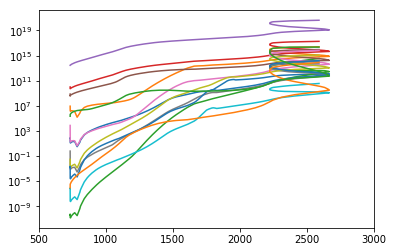

In [31]:
for g in gases:
    plt.plot(thermo['T'], thermo['n_' + g.upper()])
plt.semilogy()
plt.xlim(500, 3000)

In [32]:
# Sanity check for pressure, temperature interpolation
# Suggested by Ryan

T0 = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2500, 3000, 3500]
T1 = np.arange(100, 3000, 50)

In [34]:
test_T0 = demo.Extract_opacity(np.array([gases[0]]), P, T0, wavel, opacity_treatment)

Now reading in cross sections


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of < with parameters (reflected list(int64), float64)
Known signatures:
 * (bool, bool) -> bool
 * (int8, int8) -> bool
 * (int16, int16) -> bool
 * (int32, int32) -> bool
 * (int64, int64) -> bool
 * (uint8, uint8) -> bool
 * (uint16, uint16) -> bool
 * (uint32, uint32) -> bool
 * (uint64, uint64) -> bool
 * (float32, float32) -> bool
 * (float64, float64) -> bool
 * parameterized
[1] During: typing of intrinsic-call at /home/liac/dev/cloudacademyMap/gas_opac/opacity_demo.py (150)

File "opacity_demo.py", line 150:
def T_interpolation_init(T_grid, T):
    <source elided>
        
    if (T < T_grid[0]):   # If temperature falls off LHS of temperaure grid
    ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new
